In [2]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

# 메모리 변수 확인
#globals()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings(action='ignore')

# 한글 폰트 사용
plt.rc('font', family='NanumGothic') # For Windows

# 그래프에서 마이너스 기호가 표시
# matplotlib.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [4]:
train = pd.read_csv('train_메뉴제외.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [5]:
# 데이터 결측치 확인
print(train.info())
print()
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   중식계             1205 non-null   float64
 8   석식계             1205 non-null   float64
 9   식사가능인원          1205 non-null   float64
 10  중식결식            1205 non-null   float64
 11  석식결식            1205 non-null   float64
 12  중식강수여부          1205 non-null   float64
 13  중식기온            1205 non-null   float64
 14  중식강수량           1205 non-null   float64
 15  석식강수여부          1205 non-null   float64
 16  석식기온            1205 non-null   float64
 17  석식강수량           1205 non-null   f

## 베이스라인

In [6]:
# 월, 년 데이터 추가
def date(data):
    data['일자'] = pd.to_datetime(data['일자'])
    data['월'] = data['일자'].dt.month
    data['년'] = data['일자'].dt.year
    data['요일'] = (data['일자'].dt.weekday)+1

date(train); date(test)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     int64         
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
 10  월               50 non-null     int64         
 11  년               50 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 4.8+ KB


In [8]:
x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

### 점심, 저녁 예측 모델 각각 생성

### Lasso model

In [66]:
## Lasso model
from sklearn.linear_model import Lasso  

Lasso_params = {'alpha':np.logspace(-4, 1, 6)}

model1 = Lasso()
model2 = Lasso()

lunch_model = GridSearchCV(model1, Lasso_params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(model2, Lasso_params, scoring='neg_mean_absolute_error')

lunch_model.fit(x_train, y1_train)
dinner_model.fit(x_train, y2_train)

lunch_base_lasso = lunch_model.best_score_
dinner_base_lasso = dinner_model.best_score_

print('점심 베이스라인(Lasso) 모델 에러값(mae) : ',lunch_base_lasso)
print('저녁 베이스라인(Lasso) 모델 에러값(mae) : ',dinner_base_lasso)

점심 베이스라인(Lasso) 모델 에러값(mae) :  -100.79160667897817
저녁 베이스라인(Lasso) 모델 에러값(mae) :  -81.57103774303614


## RandomForest model

In [68]:
from sklearn.ensemble import RandomForestRegressor

params = {
    'min_samples_leaf' :[10,12,15],
    'max_depth' : [1, 5, 10, 20],
}

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

lunch_model = GridSearchCV(model1, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(model2, params, scoring='neg_mean_absolute_error')

lunch_model.fit(x_train, y1_train)
dinner_model.fit(x_train, y2_train)

lunch_base_RF = lunch_model.best_score_
dinner_base_RF = dinner_model.best_score_

print('점심 베이스라인(RF) 모델 에러값(mae) : ',lunch_base_RF)
print('저녁 베이스라인(RF) 모델 에러값(mae) : ',dinner_base_RF)

점심 베이스라인(RF) 모델 에러값(mae) :  -91.60383573595831
저녁 베이스라인(RF) 모델 에러값(mae) :  -85.21191269430051


## 데이터 전처리

### 타겟 분포 확인

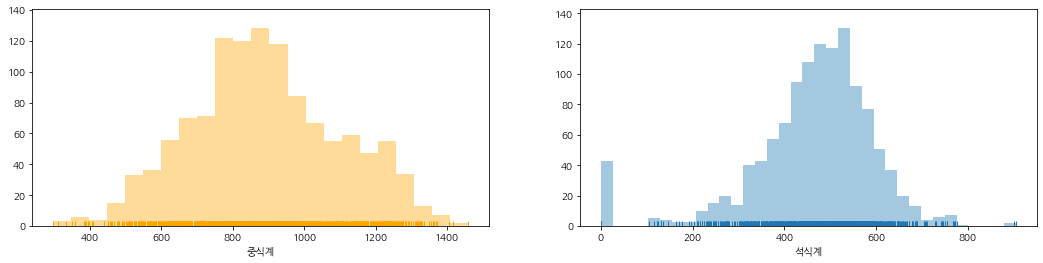

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(train["중식계"], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(train["석식계"], ax = ax[1], kde = False, rug = True)
plt.show()

- 석식계에에 0이 존재

In [15]:
# 석식계=0 인 데이터 확인
print(train[train['석식계']==0].value_counts('요일'))
train[train['석식계']==0]

요일
3    40
5     2
2     1
dtype: int64


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,식사가능인원,...,중식기온,중식강수량,석식강수여부,석식기온,석식강수량,확진자수,휴일전날,휴일다음날,월,년
204,2016-11-30,3,2689,68,207,0,0.0,1109.0,0.0,2414.0,...,7.8,0.0,1.0,8.4,1.9,0.0,0,0,11,2016
224,2016-12-28,3,2705,166,225,0,0.0,767.0,0.0,2314.0,...,3.5,0.0,0.0,1.7,0.0,0.0,0,0,12,2016
244,2017-01-25,3,2697,79,203,0,0.0,720.0,0.0,2415.0,...,1.8,0.0,0.0,2.2,0.0,0.0,0,0,1,2017
262,2017-02-22,3,2632,75,252,0,0.0,1065.0,0.0,2305.0,...,3.7,6.7,1.0,4.9,4.4,0.0,0,0,2,2017
281,2017-03-22,3,2627,53,235,0,0.0,953.0,0.0,2339.0,...,10.6,0.0,0.0,11.4,0.0,0.0,0,0,3,2017
306,2017-04-26,3,2626,45,304,0,0.0,835.0,0.0,2277.0,...,15.8,0.0,0.0,17.3,0.0,0.0,0,0,4,2017
327,2017-05-31,3,2637,43,265,0,0.0,910.0,0.0,2329.0,...,25.0,0.0,0.0,23.4,0.0,0.0,0,0,5,2017
346,2017-06-28,3,2648,58,259,0,0.0,745.0,0.0,2331.0,...,28.2,0.0,0.0,26.2,0.0,0.0,0,0,6,2017
366,2017-07-26,3,2839,254,246,0,0.0,797.0,0.0,2339.0,...,28.9,0.0,0.0,29.4,0.0,0.0,0,0,7,2017
392,2017-09-01,5,2642,177,303,45,0.0,663.0,0.0,2162.0,...,26.1,0.0,0.0,26.5,0.0,0.0,1,0,9,2017


석식계가 0인 날 총 43개
- 월별 마지막주 수요일은 '자기개발'의 날로 석식을 제공하지 않음.
- 석식을 제공하는 날 중 이용자가 0명인 날은 2017-09-27와 2018-02-14 은 공휴일 전후의 날짜임.

### 시각화및 상관관계 분석

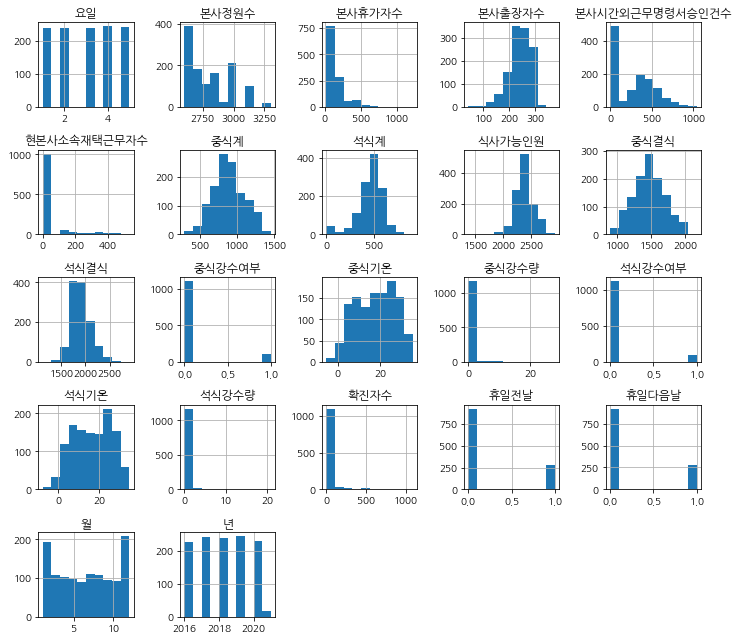

In [17]:
train.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

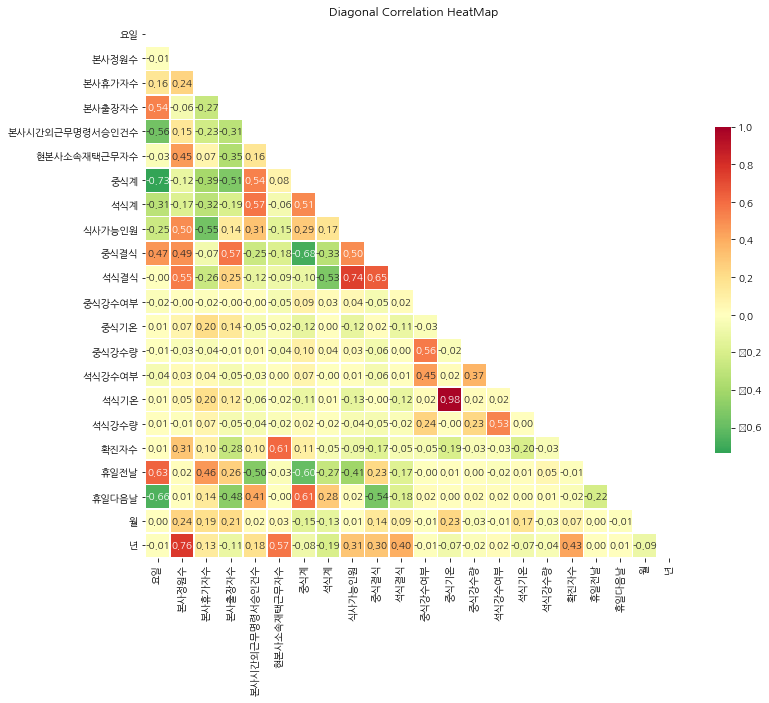

In [16]:
# 상관관계 도출
corr_matrix = train.corr()

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = train.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

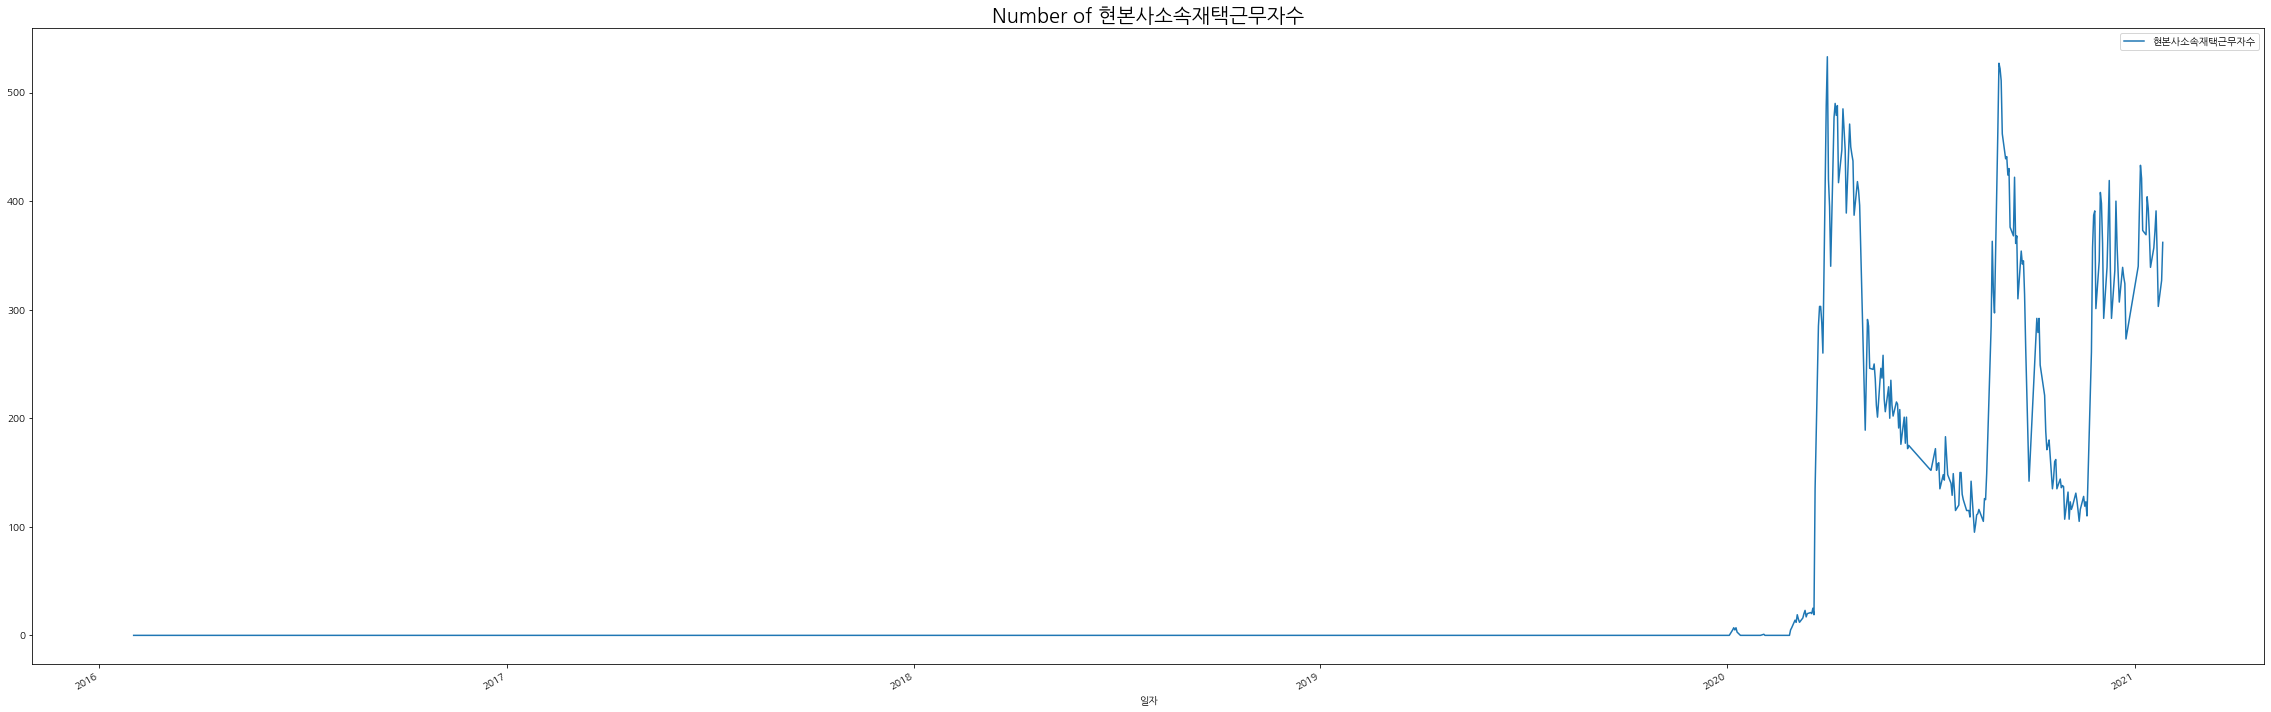

In [29]:
columns = ['현본사소속재택근무자수']
for column in columns:
    train.plot(x='일자', y=column, figsize=(40, 13))
    plt.title( f'Number of {column}', fontsize = 20)
    plt.show()

재택근무는 코로나 발생 이후부터 시행됨.

In [32]:
print(train[train['본사시간외근무명령서승인건수']==0].value_counts('요일'))

요일
3    179
5     34
dtype: int64


야근을 하지 않는 날은 수요일, 금요일임. 

## 타겟데이터 분리 후 인코딩

In [51]:
# !pip install category_encoders

In [52]:
## import OneHotEncoder, train_test_split
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split

# 데이터 정리
x = train.drop(['일자','중식계', '석식계', '중식결식', '석식결식'], axis=1)
y_lunch = train['중식계']
y_dinner = train['석식계']

## 원핫 인코딩
encoder = OneHotEncoder(use_cat_names=True, cols=['중식강수여부', '석식강수여부', '휴일전날', '휴일다음날', '월', '년', '요일'])
x = encoder.fit_transform(x)

## 모델 생성 및 성능 확인

### Lasso model

In [65]:
Lasso_params = {'alpha':np.logspace(-4, 1, 6)}

model1 = Lasso()
model2 = Lasso()

lasso_lunch_model = GridSearchCV(model1, Lasso_params, scoring='neg_mean_absolute_error')
lasso_dinner_model = GridSearchCV(model2, Lasso_params, scoring='neg_mean_absolute_error')

lasso_lunch_model.fit(x, y_lunch)
lasso_dinner_model.fit(x, y_dinner)

lasso_lunch_best = lasso_lunch_model.best_score_
lasso_dinner_best = lasso_dinner_model.best_score_

print('점심 Lasso 모델 에러값(mae) : ',lasso_lunch_best)
print('저녁 Lasso 모델 에러값(mae) : ',lasso_dinner_best)

점심 Lasso 모델 에러값(mae) :  -85.98525268402366
저녁 Lasso 모델 에러값(mae) :  -78.03703972230149


### RandomForest model

In [ ]:
params = {
    'n_estimators': [50,100,150,200,300,500,1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [1,2,3,5,6,10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 5, 10]}

model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

RF_lunch_model = GridSearchCV(model1, params, scoring='neg_mean_absolute_error')
RF_dinner_model = GridSearchCV(model2, params, scoring='neg_mean_absolute_error')

RF_lunch_model.fit(x, y_lunch)
RF_dinner_model.fit(x, y_dinner)

RF_lunch_best = RF_lunch_model.best_score_
RF_dinner_best = RF_dinner_model.best_score_

print('점심 RF 모델 에러값(mae) : ',RF_lunch_best)
print('저녁 RF 모델 에러값(mae) : ',RF_dinner_best)

In [71]:
result = pd.DataFrame({'BaseLine(Lasso)' : [lunch_base_lasso, dinner_base_lasso],
                        'BaseLine(RF)' : [lunch_base_RF, dinner_base_RF],
                       'Lasso' :[lasso_lunch_best, lasso_dinner_best], 
                       'RandomForest' : [RF_lunch_best, RF_dinner_best]})
result.index = ['중식계 best score','석식계 best score']
result

,BaseLine(Lasso),BaseLine(RF),Lasso,RandomForest
중식계 best score,-100.791607,-91.603836,-85.985253,-78.765473
석식계 best score,-81.571038,-85.211913,-78.037040,-79.788624


## 머신러닝 모델 해석

In [74]:
dkv

Note: you may need to restart the kernel to use updated packages.


In [77]:
import eli5 
from eli5.sklearn import PermutationImportance 

perm = PermutationImportance(RF_lunch_model, random_state = 42).fit(x,y_lunch) 
eli5.show_weights(perm, top = 20, feature_names = x.columns.tolist())

Weight,Feature
35.6964 ± 2.6707,본사출장자수
28.7456 ± 1.4152,본사휴가자수
14.7695 ± 2.5233,요일_1.0
14.3686 ± 1.6909,휴일다음날_1.0
12.4024 ± 1.9968,휴일다음날_0.0
9.3733 ± 0.3088,본사시간외근무명령서승인건수
8.3046 ± 0.8421,휴일전날_1.0
5.7181 ± 0.4210,본사정원수
4.8808 ± 0.8315,휴일전날_0.0
4.0314 ± 0.5756,요일_5.0
